# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Explore](#Explore)
* [Discussion](#Discussion)

# Introduction

This notebook explores the viability of a triple one-class SVM (with SGD) approach. The three SVM predictions may be used themselves for classification or may be treated as extracted features.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from gc import collect as gc_collect

# faster pandas & sklearn
import swifter

# from sklearnex import patch_sklearn

# patch_sklearn()
# del patch_sklearn

# sklearn
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# visualization
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

# warnings.filterwarnings("ignore")
del warnings

time: 3.15 s


In [4]:
# Location of cross validation data
FRILL_FEATHERS_FOLDER = "../1.0-mic-extract_FRILL_embeddings"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 118 ms


# Load data

In [5]:
data = pd.read_feather(f"{FRILL_FEATHERS_FOLDER}/dev_FRILL.feather").set_index("id")
labels = pd.read_feather(f"{FRILL_FEATHERS_FOLDER}/dev_labels.feather").set_index("id")
data.head()
data.info()
labels.head()
labels.info()

0         1         2         3         4         5         6  \
id                                                                         
0   0.119926 -0.049218  0.039702  0.141101  0.044318  0.049631  0.016178   
2   0.101377 -0.063714 -0.015971 -0.151561 -0.065328 -0.013746  0.008821   
4  -0.028015 -0.041617  0.012599 -0.031460  0.021788  0.039503  0.033654   
6  -0.008712 -0.003798 -0.052170  0.030298  0.049662  0.039806  0.056743   
8  -0.000265 -0.050629 -0.005011 -0.169305 -0.087526 -0.022268 -0.020403   

           7         8         9  ...      2038      2039      2040      2041  \
id                                ...                                           
0   0.025797 -0.104466 -0.016044  ... -0.226529 -0.091773  0.028184 -0.074794   
2   0.010461 -0.030857 -0.010367  ... -0.169826  0.051789  0.114774 -0.033263   
4   0.114422 -0.080653 -0.032090  ...  0.059661  0.020316  0.044898  0.008499   
6  -0.186714 -0.151110  0.021191  ...  0.107442  0.053569 -0.067552 -0.017051   
8  -0.149949 -0.047235  0.032980  ... -0.128375  0.128055  0.047202 -0.024305   

        2042      2043      2044      2045      2046      2047  
id                                                              
0   0.025474  0.046511 -0.002693 -0.017953 -0.146394 -0.062330  
2  -0.071615 -0.040535 -0.050813  0.021136 -0.189459  0.040756  
4   0.009812 -0.047551  0.085392  0.029538  0.057070 -0.029945  
6  -0.109469 -0.082999 -0.049325  0.031638 -0.027172  0.006479  
8  -0.168291  0.112876  0.017571  0.078376  0.099279 -0.046610  

[5 rows x 2048 columns]

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 17703 entries, 0 to 39247
Columns: 2048 entries, 0 to 2047
dtypes: float32(2048)
memory usage: 138.4 MB


index                                        file source  length  \
id                                                                     
0       0  00000+aesdd+aesdd.1+f+ang+-1+ell+el-gr.wav  aesdd  medium   
2       2  00002+aesdd+aesdd.3+m+ang+-1+ell+el-gr.wav  aesdd  medium   
4       4  00004+aesdd+aesdd.5+f+ang+-1+ell+el-gr.wav  aesdd  medium   
6       6  00006+aesdd+aesdd.1+f+ang+-1+ell+el-gr.wav  aesdd  medium   
8       8  00008+aesdd+aesdd.3+m+ang+-1+ell+el-gr.wav  aesdd  medium   

   speaker_id speaker_gender lang1  emo  valence   neg    neu    pos  
id                                                                    
0     aesdd.1              f   ell  ang        0  True  False  False  
2     aesdd.3              m   ell  ang        0  True  False  False  
4     aesdd.5              f   ell  ang        0  True  False  False  
6     aesdd.1              f   ell  ang        0  True  False  False  
8     aesdd.3              m   ell  ang        0  True  False  False

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 17703 entries, 0 to 39247
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   index           17703 non-null  int64   
 1   file            17703 non-null  object  
 2   source          17703 non-null  category
 3   length          17703 non-null  category
 4   speaker_id      17703 non-null  category
 5   speaker_gender  17703 non-null  category
 6   lang1           17703 non-null  category
 7   emo             17703 non-null  category
 8   valence         17703 non-null  int8    
 9   neg             17703 non-null  bool    
 10  neu             17703 non-null  bool    
 11  pos             17703 non-null  bool    
dtypes: bool(3), category(6), int64(1), int8(1), object(1)
memory usage: 650.1+ KB
time: 434 ms


In [6]:
hue_labels = labels.valence.replace([0, 1, 2], ["negative", "neutral", "positive"])
frill_columns = data.columns

time: 2.96 ms


# Explore

In [7]:
lda = LinearDiscriminantAnalysis().fit_transform(data, labels.valence)
data["LDA1"] = lda[:, 0]
data["LDA2"] = lda[:, 1]
neg_data = data.loc[labels.valence == 0]
neu_data = data.loc[labels.valence == 1]
pos_data = data.loc[labels.valence == 2]

time: 14.3 s


<AxesSubplot:xlabel='LDA1', ylabel='LDA2'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'LDA components')

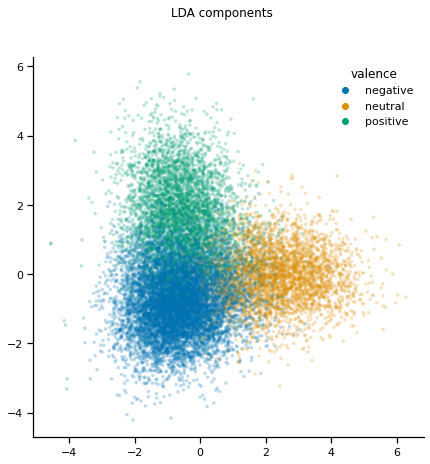

time: 599 ms


In [8]:
sns.scatterplot(
    x=data.LDA1,
    y=data.LDA2,
    hue=hue_labels,
    data=data,
    palette="colorblind",
    hue_order=["negative", "neutral", "positive"],
    alpha=0.25,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)

fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)

sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("LDA components")
plt.show()


_ = gc_collect()

In [9]:
neg_data = data.loc[labels.valence == 0]
neu_data = data.loc[labels.valence == 1]
pos_data = data.loc[labels.valence == 2]
valence_idx = {"neg": neg_data.index, "neu": neu_data.index, "pos": pos_data.index}

for valence in ("neg", "neu", "pos"):
    for n_neighbors in (10, 20, 30):
        lof = lambda: LocalOutlierFactor(
            n_neighbors=n_neighbors, novelty=True, n_jobs=-1
        )
        lofs = {
            "neg": lof().fit(neg_data[["LDA1", "LDA2"]].values),
            "neu": lof().fit(neu_data[["LDA1", "LDA2"]].values),
            "pos": lof().fit(pos_data[["LDA1", "LDA2"]].values),
        }
        key = f"componentLOF_{valence}_{n_neighbors}"
        data[key] = np.nan
        data.loc[valence_idx[valence], key] = lofs[valence].negative_outlier_factor_
        data.loc[data[key].isna(), key] = lofs[valence].score_samples(
            data.loc[data[key].isna()][["LDA1", "LDA2"]]
        )
    data[f"componentLOF_PCA_{valence}"] = PCA(1).fit_transform(
        data[[f"componentLOF_{valence}_{n_neighbors}" for n_neighbors in (10, 20, 30)]]
    )

time: 2.25 s


Text(0.5, 0.98, 'per-class LOF10 scores of LDA components')

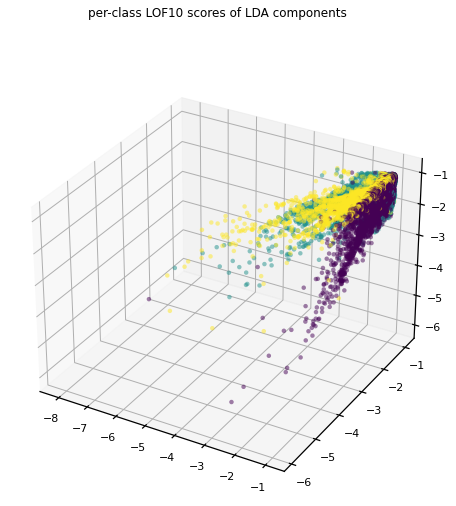

Text(0.5, 0.98, 'per-class LOF20 scores of LDA components')

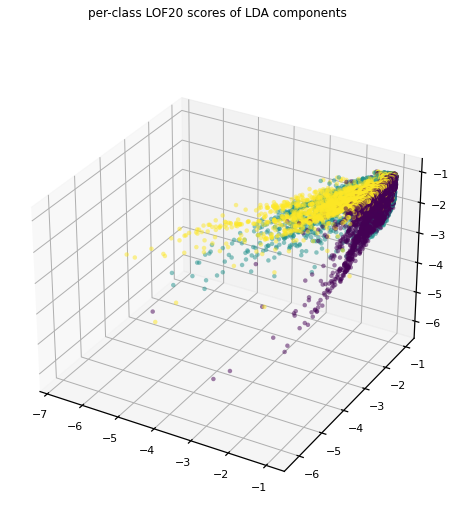

Text(0.5, 0.98, 'per-class LOF30 scores of LDA components')

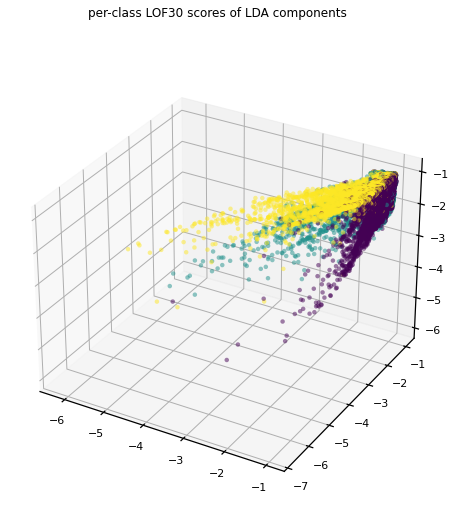

Text(0.5, 0.98, 'per-class LOF-PCA scores of LDA components')

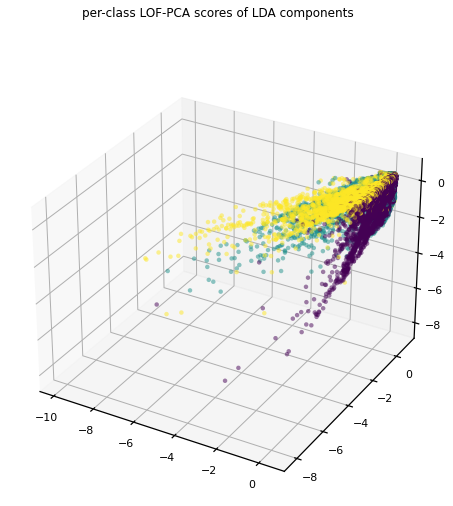

time: 3.15 s


In [10]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.componentLOF_neg_10,
    data.componentLOF_neu_10,
    data.componentLOF_pos_10,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class LOF10 scores of LDA components")
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.componentLOF_neg_20,
    data.componentLOF_neu_20,
    data.componentLOF_pos_20,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class LOF20 scores of LDA components")
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.componentLOF_neg_30,
    data.componentLOF_neu_30,
    data.componentLOF_pos_30,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class LOF30 scores of LDA components")
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.componentLOF_PCA_neg,
    data.componentLOF_PCA_neu,
    data.componentLOF_PCA_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class LOF-PCA scores of LDA components")
plt.show()

In [11]:
lda = LinearDiscriminantAnalysis().fit_transform(
    Nystroem(random_state=SEED, n_jobs=-1).fit_transform(data.loc[:, frill_columns]),
    labels.valence,
)
data["nystroemLDA1"] = lda[:, 0]
data["nystroemLDA2"] = lda[:, 1]

time: 3.19 s


<AxesSubplot:xlabel='nystroemLDA1', ylabel='nystroemLDA2'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'LDA components of Nystroem approximation')

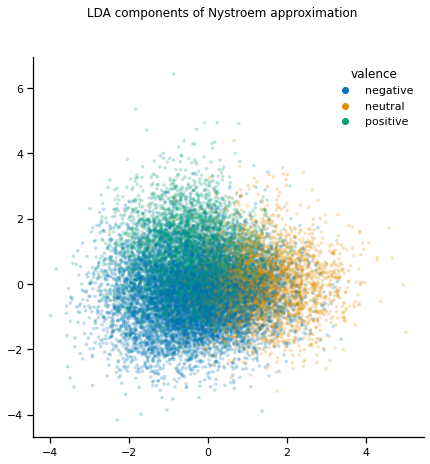

time: 1.5 s


In [12]:
sns.scatterplot(
    x=data.nystroemLDA1,
    y=data.nystroemLDA2,
    hue=hue_labels,
    data=data,
    palette="colorblind",
    hue_order=["negative", "neutral", "positive"],
    alpha=0.25,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)

fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)

sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("LDA components of Nystroem approximation")
plt.show()


_ = gc_collect()

In [13]:
lda = LinearDiscriminantAnalysis().fit_transform(
    data[["LDA1", "LDA2", "nystroemLDA1", "nystroemLDA2"]], labels.valence
)
data["doubleLDA1"] = lda[:, 0]
data["doubleLDA2"] = lda[:, 1]

time: 274 ms


<AxesSubplot:xlabel='doubleLDA1', ylabel='doubleLDA2'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'double LDA components of previously computed LDA components')

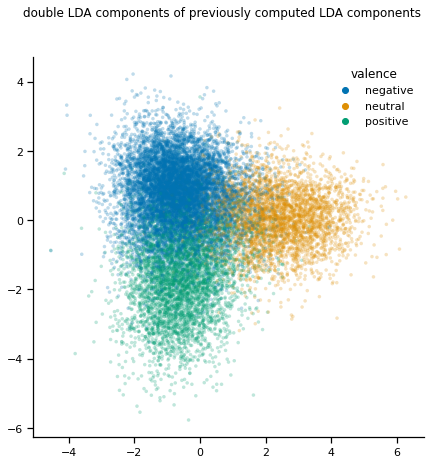

time: 1.53 s


In [14]:
sns.scatterplot(
    x=data.doubleLDA1,
    y=data.doubleLDA2,
    hue=hue_labels,
    data=data,
    palette="colorblind",
    hue_order=["negative", "neutral", "positive"],
    alpha=0.25,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)

fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)

sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("double LDA components of previously computed LDA components")
plt.show()


_ = gc_collect()

In [15]:
"original LDA"
cross_val_score(GaussianNB(), data[["LDA1", "LDA2"]], labels.valence)
"double LDA"
cross_val_score(GaussianNB(), data[["doubleLDA1", "doubleLDA2"]], labels.valence)

'original LDA'

array([0.71674668, 0.77915843, 0.94606043, 0.91129944, 0.90310734])

'double LDA'

array([0.71674668, 0.77915843, 0.94606043, 0.91129944, 0.90310734])

time: 283 ms


In [16]:
"original LDA"
cross_val_score(RidgeClassifier(), data[["LDA1", "LDA2"]], labels.valence)
"double LDA"
cross_val_score(RidgeClassifier(), data[["doubleLDA1", "doubleLDA2"]], labels.valence)

'original LDA'

array([0.71872352, 0.77379271, 0.94238916, 0.90621469, 0.90338983])

'double LDA'

array([0.71872352, 0.77379271, 0.94238916, 0.90621469, 0.90338983])

time: 364 ms


In [17]:
lda = LinearDiscriminantAnalysis().fit_transform(
    data[
        [
            "LDA1",
            "LDA2",
            "componentLOF_PCA_neg",
            "componentLOF_PCA_neu",
            "componentLOF_PCA_pos",
        ]
    ],
    labels.valence,
)
data["doubleLDAv2-1"] = lda[:, 0]
data["doubleLDAv2-2"] = lda[:, 1]

time: 65 ms


<AxesSubplot:xlabel='doubleLDAv2-1', ylabel='doubleLDAv2-2'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'double LDA components of previously computed LDA components')

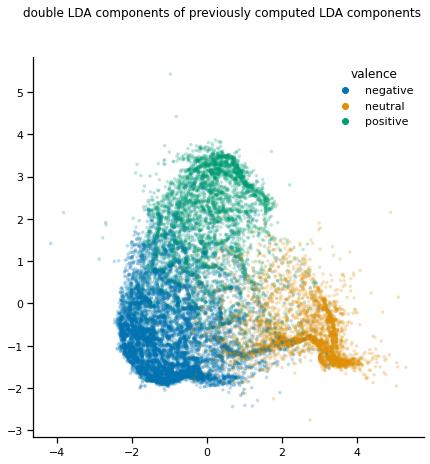

time: 1.82 s


In [18]:
sns.scatterplot(
    x=data["doubleLDAv2-1"],
    y=data["doubleLDAv2-2"],
    hue=hue_labels,
    data=data,
    palette="colorblind",
    hue_order=["negative", "neutral", "positive"],
    alpha=0.25,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)

fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)

sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("double LDA components of previously computed LDA components")
plt.show()


_ = gc_collect()

In [19]:
"original LDA"
cross_val_score(GaussianNB(), data[["LDA1", "LDA2"]], labels.valence)
"double LDA"
cross_val_score(GaussianNB(), data[["doubleLDAv2-1", "doubleLDAv2-2"]], labels.valence)

'original LDA'

array([0.71674668, 0.77915843, 0.94606043, 0.91129944, 0.90310734])

'double LDA'

array([0.71900593, 0.77040384, 0.94154194, 0.90734463, 0.90112994])

time: 323 ms


In [20]:
"original LDA"
cross_val_score(RidgeClassifier(), data[["LDA1", "LDA2"]], labels.valence)
"double LDA"
cross_val_score(
    RidgeClassifier(), data[["doubleLDAv2-1", "doubleLDAv2-2"]], labels.valence
)

'original LDA'

array([0.71872352, 0.77379271, 0.94238916, 0.90621469, 0.90338983])

'double LDA'

array([0.71505225, 0.77351031, 0.94267156, 0.91016949, 0.90254237])

time: 356 ms


In [21]:
lda = LinearDiscriminantAnalysis().fit_transform(data, labels.valence)
data["bigLDA1"] = lda[:, 0]
data["bigLDA2"] = lda[:, 1]

time: 38.7 s


<AxesSubplot:xlabel='bigLDA1', ylabel='bigLDA2'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'double LDA components of previously computed LDA components')

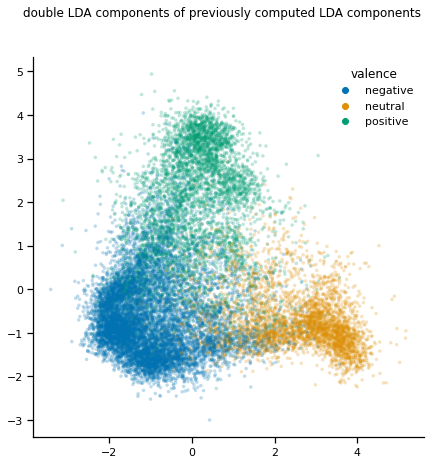

time: 1.35 s


In [22]:
sns.scatterplot(
    x=data["bigLDA1"],
    y=data["bigLDA2"],
    hue=hue_labels,
    data=data,
    palette="colorblind",
    hue_order=["negative", "neutral", "positive"],
    alpha=0.25,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)

fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)

sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("double LDA components of previously computed LDA components")
plt.show()


_ = gc_collect()

In [23]:
"original LDA"
cross_val_score(GaussianNB(), data[["LDA1", "LDA2"]], labels.valence)
"big LDA"
cross_val_score(GaussianNB(), data[["bigLDA1", "bigLDA2"]], labels.valence)

'original LDA'

array([0.71674668, 0.77915843, 0.94606043, 0.91129944, 0.90310734])

'big LDA'

array([0.72917255, 0.78085287, 0.94069472, 0.91214689, 0.90508475])

time: 304 ms


In [24]:
"original LDA"
cross_val_score(RidgeClassifier(), data[["LDA1", "LDA2"]], labels.valence)
"double LDA"
cross_val_score(RidgeClassifier(), data[["bigLDA1", "bigLDA2"]], labels.valence)

'original LDA'

array([0.71872352, 0.77379271, 0.94238916, 0.90621469, 0.90338983])

'double LDA'

array([0.72465405, 0.78480655, 0.94408359, 0.91299435, 0.9079096 ])

time: 408 ms


In [25]:
rf = RandomForestClassifier().fit(data, labels.valence)

time: 20.1 s


In [26]:
importances = pd.DataFrame(
    zip(data.columns, rf.feature_importances_), columns=["feature", "importance"]
).sort_values(by=["importance", "feature"], ascending=False)

time: 78.1 ms


In [27]:
importances.head(25)

feature  importance
2049                  LDA2    0.043490
2048                  LDA1    0.041534
2066         doubleLDAv2-1    0.039251
2068               bigLDA1    0.035551
2067         doubleLDAv2-2    0.035041
2065            doubleLDA2    0.031591
2069               bigLDA2    0.031523
2052   componentLOF_neg_30    0.027076
2064            doubleLDA1    0.022344
2057  componentLOF_PCA_neu    0.021325
2053  componentLOF_PCA_neg    0.020556
2060   componentLOF_pos_30    0.015674
2056   componentLOF_neu_30    0.015296
2051   componentLOF_neg_20    0.015094
2055   componentLOF_neu_20    0.014023
2050   componentLOF_neg_10    0.013303
2059   componentLOF_pos_20    0.013274
2061  componentLOF_PCA_pos    0.013102
2062          nystroemLDA1    0.012031
2058   componentLOF_pos_10    0.008918
2054   componentLOF_neu_10    0.007914
2063          nystroemLDA2    0.005410
878                    878    0.002555
352                    352    0.002058
1128                  1128    0.001625

time: 28 ms


In [28]:
top22 = importances.head(22).feature.values.tolist()
rf = RandomForestClassifier().fit(data.loc[:, top22], labels.valence)

time: 2.29 s


In [29]:
importances = pd.DataFrame(
    zip(data.loc[:, top22].columns, rf.feature_importances_),
    columns=["feature", "importance"],
).sort_values(by=["importance", "feature"], ascending=False)
importances

feature  importance
3                bigLDA1    0.097895
6                bigLDA2    0.090373
0                   LDA2    0.083339
8             doubleLDA1    0.082330
1                   LDA1    0.079355
5             doubleLDA2    0.077206
2          doubleLDAv2-1    0.063231
4          doubleLDAv2-2    0.054932
7    componentLOF_neg_30    0.052362
13   componentLOF_neg_20    0.038300
10  componentLOF_PCA_neg    0.030881
14   componentLOF_neu_20    0.026786
11   componentLOF_pos_30    0.025523
12   componentLOF_neu_30    0.025327
9   componentLOF_PCA_neu    0.024100
15   componentLOF_neg_10    0.023384
16   componentLOF_pos_20    0.023350
17  componentLOF_PCA_pos    0.022467
19   componentLOF_pos_10    0.020382
20   componentLOF_neu_10    0.019700
18          nystroemLDA1    0.019408
21          nystroemLDA2    0.019371

time: 91.1 ms


In [30]:
neg_classifier = SGDOneClassSVM(verbose=1, random_state=SEED).fit(
    neg_data.loc[:, frill_columns]
)
neu_classifier = SGDOneClassSVM(verbose=1, random_state=SEED).fit(
    neu_data.loc[:, frill_columns]
)
pos_classifier = SGDOneClassSVM(verbose=1, random_state=SEED).fit(
    pos_data.loc[:, frill_columns]
)

-- Epoch 1
Norm: 2.42, NNZs: 2048, Bias: -3.159152, T: 9706, Avg. loss: 0.357523
Total training time: 0.19 seconds.
-- Epoch 2
Norm: 2.47, NNZs: 2048, Bias: -3.272793, T: 19412, Avg. loss: 0.398304
Total training time: 0.31 seconds.
-- Epoch 3
Norm: 2.50, NNZs: 2048, Bias: -3.333058, T: 29118, Avg. loss: 0.411292
Total training time: 0.39 seconds.
-- Epoch 4
Norm: 2.51, NNZs: 2048, Bias: -3.372254, T: 38824, Avg. loss: 0.419662
Total training time: 0.45 seconds.
-- Epoch 5
Norm: 2.53, NNZs: 2048, Bias: -3.399204, T: 48530, Avg. loss: 0.429245
Total training time: 0.57 seconds.
-- Epoch 6
Norm: 2.54, NNZs: 2048, Bias: -3.422870, T: 58236, Avg. loss: 0.428465
Total training time: 0.65 seconds.
Convergence after 6 epochs took 0.66 seconds
-- Epoch 1
Norm: 2.54, NNZs: 2048, Bias: -3.753569, T: 3553, Avg. loss: 0.295105
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 2.65, NNZs: 2048, Bias: -3.919634, T: 7106, Avg. loss: 0.342515
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 2.69,

In [31]:
data["ocsvm_sgdlinear_neg"] = neg_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_sgdlinear_neu"] = neu_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_sgdlinear_pos"] = pos_classifier.score_samples(data.loc[:, frill_columns])

time: 4.14 s


Text(0.5, 0.98, 'per-class ocSGDlinear scores of FRILL embeddings')

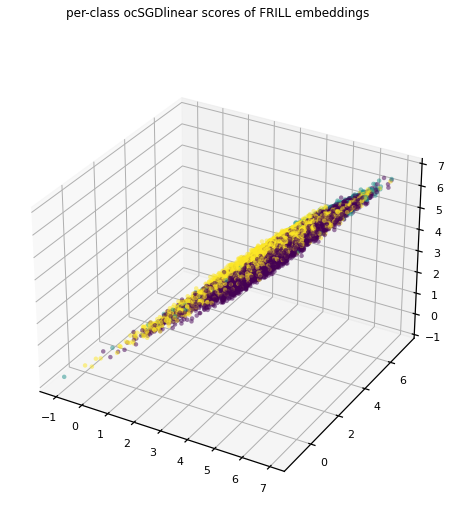

time: 875 ms


In [32]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.ocsvm_sgdlinear_neg,
    data.ocsvm_sgdlinear_neu,
    data.ocsvm_sgdlinear_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class ocSGDlinear scores of FRILL embeddings")
plt.show()

In [33]:
lda = LinearDiscriminantAnalysis().fit_transform(
    data[["ocsvm_sgdlinear_neg", "ocsvm_sgdlinear_neu", "ocsvm_sgdlinear_pos"]],
    labels.valence,
)
data["sgdlinear_LDA1"] = lda[:, 0]
data["sgdlinear_LDA2"] = lda[:, 1]

time: 83.1 ms


<AxesSubplot:xlabel='sgdlinear_LDA1', ylabel='sgdlinear_LDA2'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'LDA components of SGD_linear one-class scores')

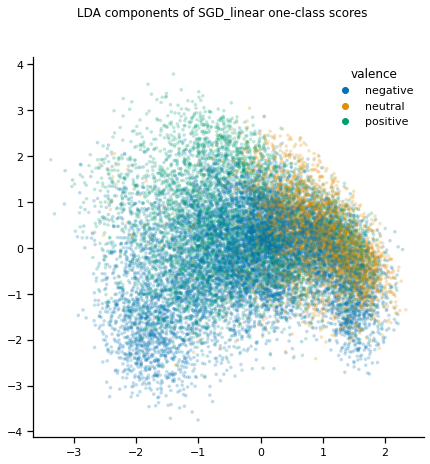

time: 1.47 s


In [34]:
sns.scatterplot(
    x=data["sgdlinear_LDA1"],
    y=data["sgdlinear_LDA2"],
    hue=hue_labels,
    data=data,
    palette="colorblind",
    hue_order=["negative", "neutral", "positive"],
    alpha=0.25,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)

fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)

sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("LDA components of SGD_linear one-class scores")
plt.show()


_ = gc_collect()

In [35]:
neg_classifier = SGDOneClassSVM(verbose=1, random_state=SEED).fit(
    neg_data.loc[:, ["LDA1", "LDA2"]]
)
neu_classifier = SGDOneClassSVM(verbose=1, random_state=SEED).fit(
    neu_data.loc[:, ["LDA1", "LDA2"]]
)
pos_classifier = SGDOneClassSVM(verbose=1, random_state=SEED).fit(
    pos_data.loc[:, ["LDA1", "LDA2"]]
)

-- Epoch 1
Norm: 0.37, NNZs: 2, Bias: 0.636477, T: 9706, Avg. loss: 0.160781
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.36, NNZs: 2, Bias: 0.641876, T: 19412, Avg. loss: 0.148604
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 0.35, NNZs: 2, Bias: 0.646671, T: 29118, Avg. loss: 0.146364
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 0.35, NNZs: 2, Bias: 0.648005, T: 38824, Avg. loss: 0.146114
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 0.35, NNZs: 2, Bias: 0.650097, T: 48530, Avg. loss: 0.145929
Total training time: 0.02 seconds.
-- Epoch 6
Norm: 0.35, NNZs: 2, Bias: 0.652722, T: 58236, Avg. loss: 0.145511
Total training time: 0.02 seconds.
-- Epoch 7
Norm: 0.35, NNZs: 2, Bias: 0.653334, T: 67942, Avg. loss: 0.144351
Total training time: 0.02 seconds.
-- Epoch 8
Norm: 0.35, NNZs: 2, Bias: 0.653250, T: 77648, Avg. loss: 0.143715
Total training time: 0.03 seconds.
-- Epoch 9
Norm: 0.35, NNZs: 2, Bias: 0.653319, T: 87354, Avg. loss: 0.143742
Total training time

In [36]:
data["LDA_sgdlinear_neg"] = neg_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_sgdlinear_neu"] = neu_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_sgdlinear_pos"] = pos_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])

time: 122 ms


Text(0.5, 0.98, 'per-class ocSGDlinear scores of LDA components')

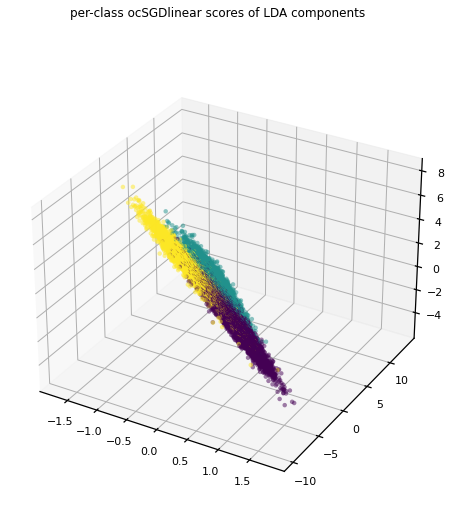

time: 841 ms


In [37]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.LDA_sgdlinear_neg,
    data.LDA_sgdlinear_neu,
    data.LDA_sgdlinear_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class ocSGDlinear scores of LDA components")
plt.show()

Text(0.5, 0.98, 'per-class oc-rbf scores of FRILL embeddings')

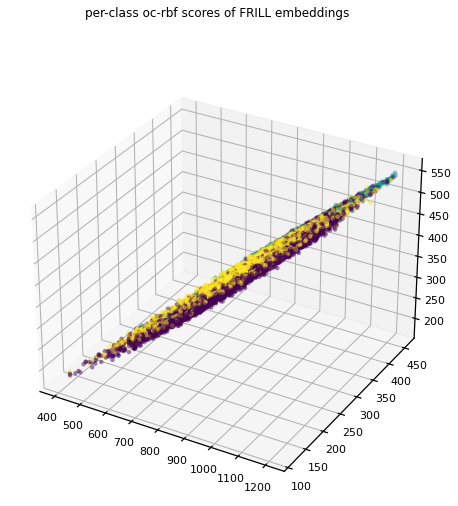

<AxesSubplot:xlabel='oc-rbf_LDA1', ylabel='oc-rbf_LDA2'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'LDA components of rbf one-class scores of FRILL embeddings')

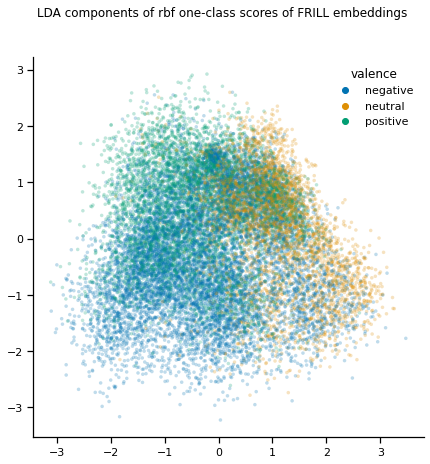

time: 12min 51s


In [38]:
neg_classifier = OneClassSVM(kernel="rbf").fit(neg_data.loc[:, frill_columns])
neu_classifier = OneClassSVM(kernel="rbf").fit(neu_data.loc[:, frill_columns])
pos_classifier = OneClassSVM(kernel="rbf").fit(pos_data.loc[:, frill_columns])
data["ocsvm_rbf_neg"] = neg_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_rbf_neu"] = neu_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_rbf_pos"] = pos_classifier.score_samples(data.loc[:, frill_columns])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.ocsvm_rbf_neg,
    data.ocsvm_rbf_neu,
    data.ocsvm_rbf_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-rbf scores of FRILL embeddings")
plt.show()

lda = LinearDiscriminantAnalysis().fit_transform(
    data[["ocsvm_rbf_neg", "ocsvm_rbf_neu", "ocsvm_rbf_pos"]], labels.valence,
)
data["oc-rbf_LDA1"] = lda[:, 0]
data["oc-rbf_LDA2"] = lda[:, 1]
sns.scatterplot(
    x=data["oc-rbf_LDA1"],
    y=data["oc-rbf_LDA2"],
    hue=hue_labels,
    data=data,
    palette="colorblind",
    hue_order=["negative", "neutral", "positive"],
    alpha=0.25,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)
fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)
sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("LDA components of rbf one-class scores of FRILL embeddings")
plt.show()


_ = gc_collect()

Text(0.5, 0.98, 'per-class oc-sigmoid scores of FRILL embeddings')

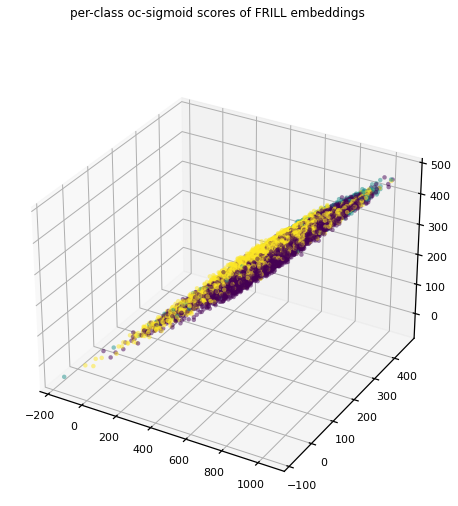

<AxesSubplot:xlabel='oc-sigmoid_LDA1', ylabel='oc-sigmoid_LDA2'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'LDA components of sigmoid one-class scores of FRILL embeddings')

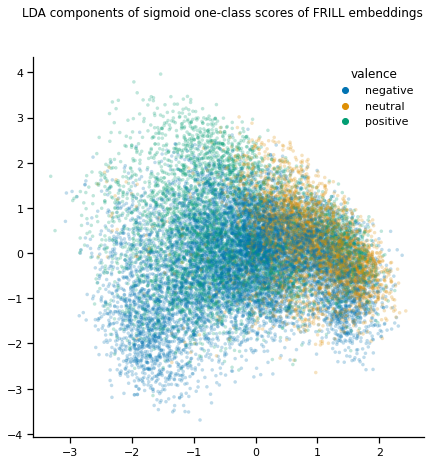

time: 8min 20s


In [39]:
neg_classifier = OneClassSVM(kernel="sigmoid").fit(neg_data.loc[:, frill_columns])
neu_classifier = OneClassSVM(kernel="sigmoid").fit(neu_data.loc[:, frill_columns])
pos_classifier = OneClassSVM(kernel="sigmoid").fit(pos_data.loc[:, frill_columns])
data["ocsvm_sigmoid_neg"] = neg_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_sigmoid_neu"] = neu_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_sigmoid_pos"] = pos_classifier.score_samples(data.loc[:, frill_columns])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.ocsvm_sigmoid_neg,
    data.ocsvm_sigmoid_neu,
    data.ocsvm_sigmoid_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-sigmoid scores of FRILL embeddings")
plt.show()

lda = LinearDiscriminantAnalysis().fit_transform(
    data[["ocsvm_sigmoid_neg", "ocsvm_sigmoid_neu", "ocsvm_sigmoid_pos"]],
    labels.valence,
)
data["oc-sigmoid_LDA1"] = lda[:, 0]
data["oc-sigmoid_LDA2"] = lda[:, 1]
sns.scatterplot(
    x=data["oc-sigmoid_LDA1"],
    y=data["oc-sigmoid_LDA2"],
    hue=hue_labels,
    data=data,
    palette="colorblind",
    hue_order=["negative", "neutral", "positive"],
    alpha=0.25,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)
fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)
sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("LDA components of sigmoid one-class scores of FRILL embeddings")
plt.show()


_ = gc_collect()

Text(0.5, 0.98, 'per-class oc-poly2 scores of FRILL embeddings')

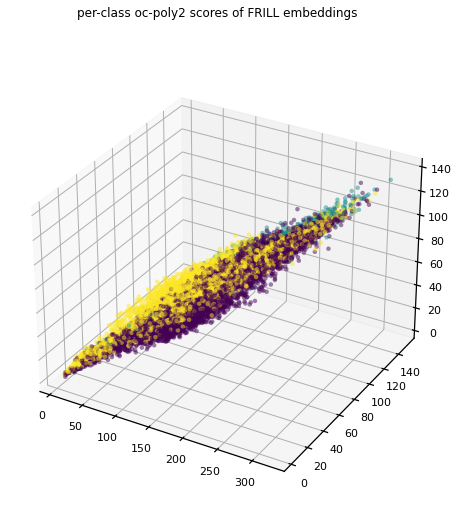

<AxesSubplot:xlabel='oc-poly2_LDA1', ylabel='oc-poly2_LDA2'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'LDA components of poly2 one-class scores of FRILL embeddings')

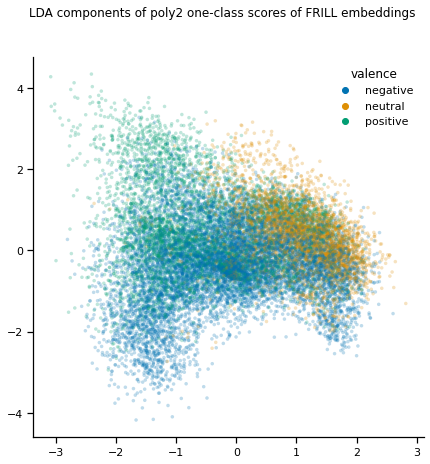

time: 5min 30s


In [40]:
neg_classifier = OneClassSVM(kernel="poly", degree=2).fit(
    neg_data.loc[:, frill_columns]
)
neu_classifier = OneClassSVM(kernel="poly", degree=2).fit(
    neu_data.loc[:, frill_columns]
)
pos_classifier = OneClassSVM(kernel="poly", degree=2).fit(
    pos_data.loc[:, frill_columns]
)
data["ocsvm_poly2_neg"] = neg_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_poly2_neu"] = neu_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_poly2_pos"] = pos_classifier.score_samples(data.loc[:, frill_columns])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.ocsvm_poly2_neg,
    data.ocsvm_poly2_neu,
    data.ocsvm_poly2_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-poly2 scores of FRILL embeddings")
plt.show()

lda = LinearDiscriminantAnalysis().fit_transform(
    data[["ocsvm_poly2_neg", "ocsvm_poly2_neu", "ocsvm_poly2_pos"]], labels.valence,
)
data["oc-poly2_LDA1"] = lda[:, 0]
data["oc-poly2_LDA2"] = lda[:, 1]
sns.scatterplot(
    x=data["oc-poly2_LDA1"],
    y=data["oc-poly2_LDA2"],
    hue=hue_labels,
    data=data,
    palette="colorblind",
    hue_order=["negative", "neutral", "positive"],
    alpha=0.25,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)
fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)
sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("LDA components of poly2 one-class scores of FRILL embeddings")
plt.show()


_ = gc_collect()

Text(0.5, 0.98, 'per-class oc-poly3 scores of FRILL embeddings')

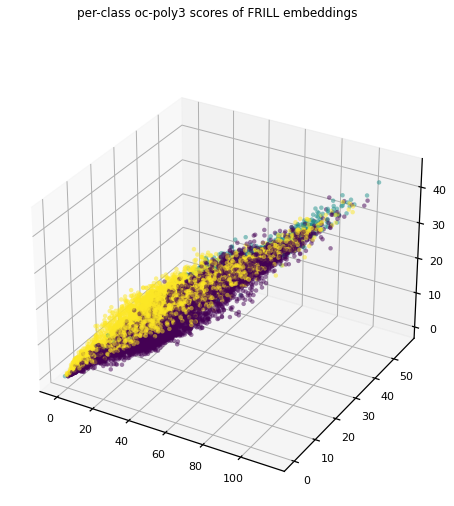

<AxesSubplot:xlabel='oc-poly3_LDA1', ylabel='oc-poly3_LDA2'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'LDA components of poly3 one-class scores of FRILL embeddings')

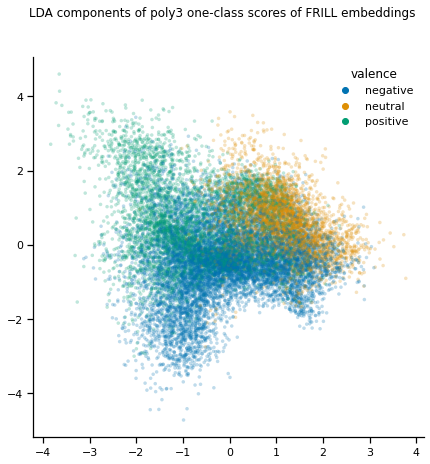

time: 7min 50s


In [41]:
neg_classifier = OneClassSVM(kernel="poly", degree=3).fit(
    neg_data.loc[:, frill_columns]
)
neu_classifier = OneClassSVM(kernel="poly", degree=3).fit(
    neu_data.loc[:, frill_columns]
)
pos_classifier = OneClassSVM(kernel="poly", degree=3).fit(
    pos_data.loc[:, frill_columns]
)
data["ocsvm_poly3_neg"] = neg_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_poly3_neu"] = neu_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_poly3_pos"] = pos_classifier.score_samples(data.loc[:, frill_columns])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.ocsvm_poly3_neg,
    data.ocsvm_poly3_neu,
    data.ocsvm_poly3_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-poly3 scores of FRILL embeddings")
plt.show()

lda = LinearDiscriminantAnalysis().fit_transform(
    data[["ocsvm_poly3_neg", "ocsvm_poly3_neu", "ocsvm_poly3_pos"]], labels.valence,
)
data["oc-poly3_LDA1"] = lda[:, 0]
data["oc-poly3_LDA2"] = lda[:, 1]
sns.scatterplot(
    x=data["oc-poly3_LDA1"],
    y=data["oc-poly3_LDA2"],
    hue=hue_labels,
    data=data,
    palette="colorblind",
    hue_order=["negative", "neutral", "positive"],
    alpha=0.25,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)
fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)
sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("LDA components of poly3 one-class scores of FRILL embeddings")
plt.show()


_ = gc_collect()

Text(0.5, 0.98, 'per-class oc-poly4 scores of FRILL embeddings')

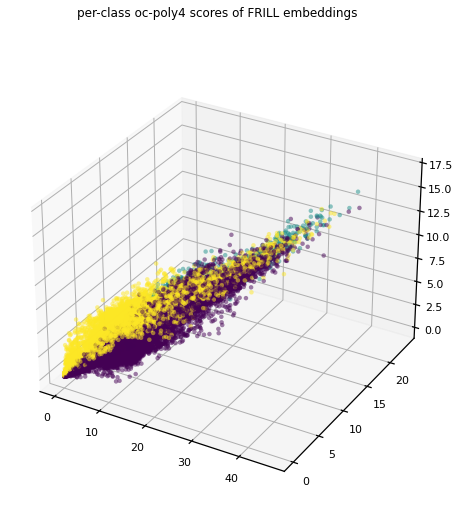

<AxesSubplot:xlabel='oc-poly4_LDA1', ylabel='oc-poly4_LDA2'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'LDA components of poly4 one-class scores of FRILL embeddings')

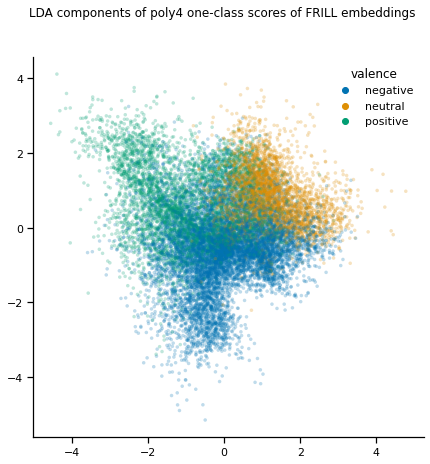

time: 9min 47s


In [42]:
neg_classifier = OneClassSVM(kernel="poly", degree=4).fit(
    neg_data.loc[:, frill_columns]
)
neu_classifier = OneClassSVM(kernel="poly", degree=4).fit(
    neu_data.loc[:, frill_columns]
)
pos_classifier = OneClassSVM(kernel="poly", degree=4).fit(
    pos_data.loc[:, frill_columns]
)
data["ocsvm_poly4_neg"] = neg_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_poly4_neu"] = neu_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_poly4_pos"] = pos_classifier.score_samples(data.loc[:, frill_columns])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.ocsvm_poly4_neg,
    data.ocsvm_poly4_neu,
    data.ocsvm_poly4_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-poly4 scores of FRILL embeddings")
plt.show()

lda = LinearDiscriminantAnalysis().fit_transform(
    data[["ocsvm_poly4_neg", "ocsvm_poly4_neu", "ocsvm_poly4_pos"]], labels.valence,
)
data["oc-poly4_LDA1"] = lda[:, 0]
data["oc-poly4_LDA2"] = lda[:, 1]
sns.scatterplot(
    x=data["oc-poly4_LDA1"],
    y=data["oc-poly4_LDA2"],
    hue=hue_labels,
    data=data,
    palette="colorblind",
    hue_order=["negative", "neutral", "positive"],
    alpha=0.25,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)
fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)
sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("LDA components of poly4 one-class scores of FRILL embeddings")
plt.show()


_ = gc_collect()

Text(0.5, 0.98, 'per-class oc-rbf scores of LDA components')

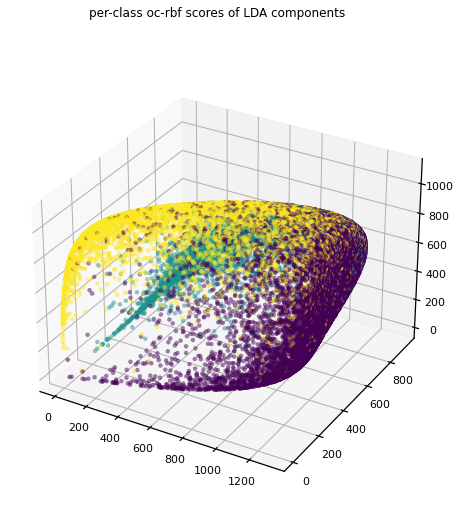

time: 52.4 s


In [43]:
neg_classifier = OneClassSVM(kernel="rbf").fit(neg_data.loc[:, ["LDA1", "LDA2"]])
neu_classifier = OneClassSVM(kernel="rbf").fit(neu_data.loc[:, ["LDA1", "LDA2"]])
pos_classifier = OneClassSVM(kernel="rbf").fit(pos_data.loc[:, ["LDA1", "LDA2"]])
data["LDA_rbf_neg"] = neg_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_rbf_neu"] = neu_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_rbf_pos"] = pos_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.LDA_rbf_neg,
    data.LDA_rbf_neu,
    data.LDA_rbf_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-rbf scores of LDA components")
plt.show()

Text(0.5, 0.98, 'per-class oc-sigmoid scores of LDA components')

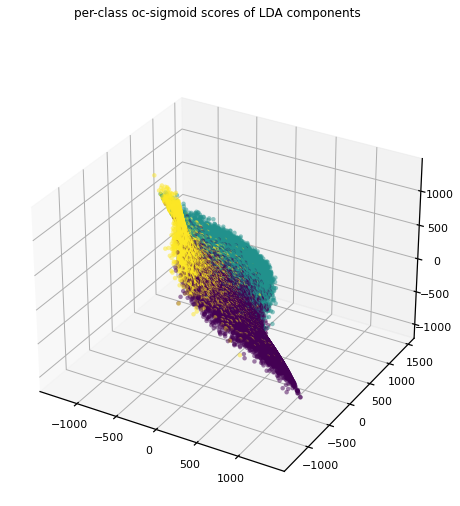

time: 37 s


In [44]:
neg_classifier = OneClassSVM(kernel="sigmoid").fit(neg_data.loc[:, ["LDA1", "LDA2"]])
neu_classifier = OneClassSVM(kernel="sigmoid").fit(neu_data.loc[:, ["LDA1", "LDA2"]])
pos_classifier = OneClassSVM(kernel="sigmoid").fit(pos_data.loc[:, ["LDA1", "LDA2"]])
data["LDA_sigmoid_neg"] = neg_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_sigmoid_neu"] = neu_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_sigmoid_pos"] = pos_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.LDA_sigmoid_neg,
    data.LDA_sigmoid_neu,
    data.LDA_sigmoid_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-sigmoid scores of LDA components")
plt.show()

Text(0.5, 0.98, 'per-class oc-poly2 scores of LDA components')

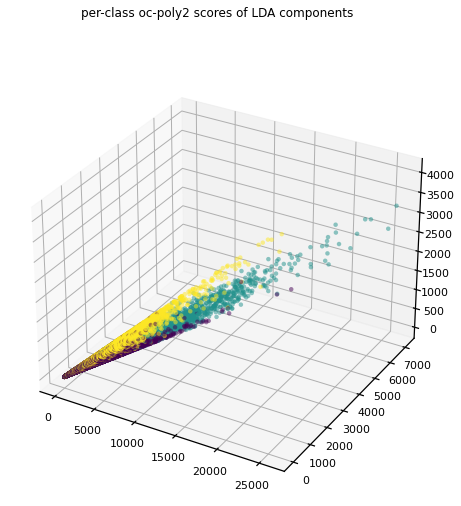

time: 32.4 s


In [45]:
neg_classifier = OneClassSVM(kernel="poly", degree=2).fit(
    neg_data.loc[:, ["LDA1", "LDA2"]]
)
neu_classifier = OneClassSVM(kernel="poly", degree=2).fit(
    neu_data.loc[:, ["LDA1", "LDA2"]]
)
pos_classifier = OneClassSVM(kernel="poly", degree=2).fit(
    pos_data.loc[:, ["LDA1", "LDA2"]]
)
data["LDA_poly2_neg"] = neg_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_poly2_neu"] = neu_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_poly2_pos"] = pos_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.LDA_poly2_neg,
    data.LDA_poly2_neu,
    data.LDA_poly2_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-poly2 scores of LDA components")
plt.show()

Text(0.5, 0.98, 'per-class oc-poly3 scores of LDA components')

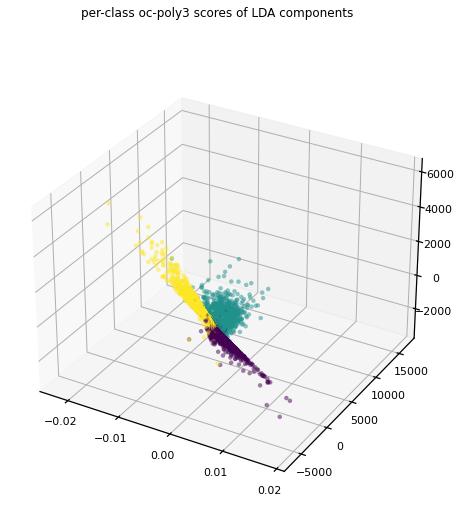

time: 24.7 s


In [46]:
neg_classifier = OneClassSVM(kernel="poly", degree=3).fit(
    neg_data.loc[:, ["LDA1", "LDA2"]]
)
neu_classifier = OneClassSVM(kernel="poly", degree=3).fit(
    neu_data.loc[:, ["LDA1", "LDA2"]]
)
pos_classifier = OneClassSVM(kernel="poly", degree=3).fit(
    pos_data.loc[:, ["LDA1", "LDA2"]]
)
data["LDA_poly3_neg"] = neg_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_poly3_neu"] = neu_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_poly3_pos"] = pos_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.LDA_poly3_neg,
    data.LDA_poly3_neu,
    data.LDA_poly3_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-poly3 scores of LDA components")
plt.show()

Text(0.5, 0.98, 'per-class oc-poly4 scores of LDA components')

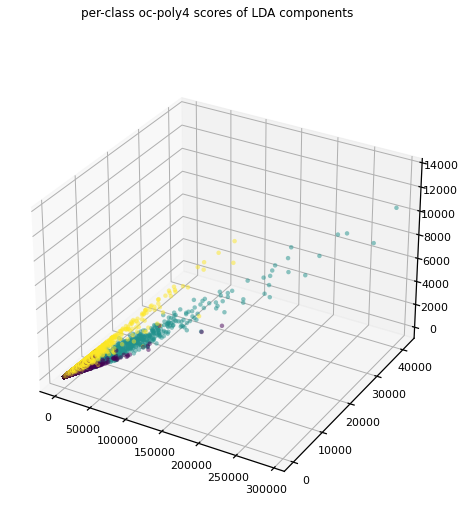

time: 27.3 s


In [47]:
neg_classifier = OneClassSVM(kernel="poly", degree=4).fit(
    neg_data.loc[:, ["LDA1", "LDA2"]]
)
neu_classifier = OneClassSVM(kernel="poly", degree=4).fit(
    neu_data.loc[:, ["LDA1", "LDA2"]]
)
pos_classifier = OneClassSVM(kernel="poly", degree=4).fit(
    pos_data.loc[:, ["LDA1", "LDA2"]]
)
data["LDA_poly4_neg"] = neg_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_poly4_neu"] = neu_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_poly4_pos"] = pos_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.LDA_poly4_neg,
    data.LDA_poly4_neu,
    data.LDA_poly4_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-poly4 scores of LDA components")
plt.show()

In [10]:
neg_classifier = OneClassSVM(kernel="poly", degree=5).fit(
    neg_data.loc[:, frill_columns]
)
neu_classifier = OneClassSVM(kernel="poly", degree=5).fit(
    neu_data.loc[:, frill_columns]
)
pos_classifier = OneClassSVM(kernel="poly", degree=5).fit(
    pos_data.loc[:, frill_columns]
)
data["ocsvm_poly5_neg"] = neg_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_poly5_neu"] = neu_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_poly5_pos"] = pos_classifier.score_samples(data.loc[:, frill_columns])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.ocsvm_poly5_neg,
    data.ocsvm_poly5_neu,
    data.ocsvm_poly5_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-poly5 scores of FRILL embeddings")
plt.show()

lda = LinearDiscriminantAnalysis().fit_transform(
    data[["ocsvm_poly5_neg", "ocsvm_poly5_neu", "ocsvm_poly5_pos"]], labels.valence,
)
data["oc-poly5_LDA1"] = lda[:, 0]
data["oc-poly5_LDA2"] = lda[:, 1]
sns.scatterplot(
    x=data["oc-poly5_LDA1"],
    y=data["oc-poly5_LDA2"],
    hue=hue_labels,
    data=data,
    palette="colorblind",
    hue_order=["negative", "neutral", "positive"],
    alpha=0.25,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)
fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)
sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("LDA components of poly5 one-class scores of FRILL embeddings")
plt.show()

In [10]:
neg_classifier = OneClassSVM(kernel="poly", degree=5)
fit_data = neg_data.loc[:, ["LDA1", "LDA2"]]
_ = gc_collect()

time: 183 ms


In [11]:
neg_classifier.fit(fit_data)

OneClassSVM(degree=5, kernel='poly')

time: 15min 7s


Text(0.5, 0.98, 'per-class oc-poly5 scores of LDA components')

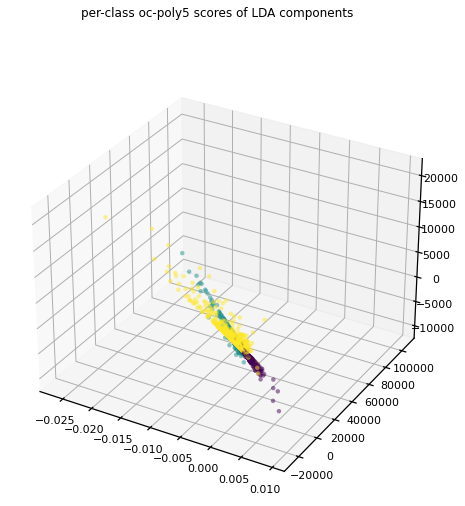

time: 6.45 s


In [12]:
neu_classifier = OneClassSVM(kernel="poly", degree=5).fit(
    neu_data.loc[:, ["LDA1", "LDA2"]]
)
pos_classifier = OneClassSVM(kernel="poly", degree=5).fit(
    pos_data.loc[:, ["LDA1", "LDA2"]]
)
data["LDA_poly5_neg"] = neg_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_poly5_neu"] = neu_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_poly5_pos"] = pos_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.LDA_poly5_neg,
    data.LDA_poly5_neu,
    data.LDA_poly5_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-poly5 scores of LDA components")
plt.show()

_ = gc_collect()

Text(0.5, 0.98, 'per-class oc-poly6 scores of FRILL embeddings')

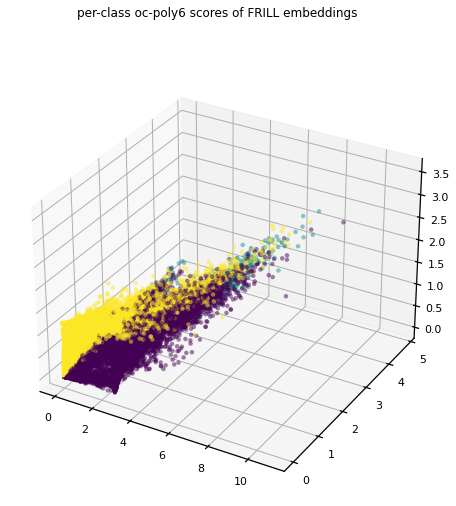

<AxesSubplot:xlabel='oc-poly6_LDA1', ylabel='oc-poly6_LDA2'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'LDA components of poly6 one-class scores of FRILL embeddings')

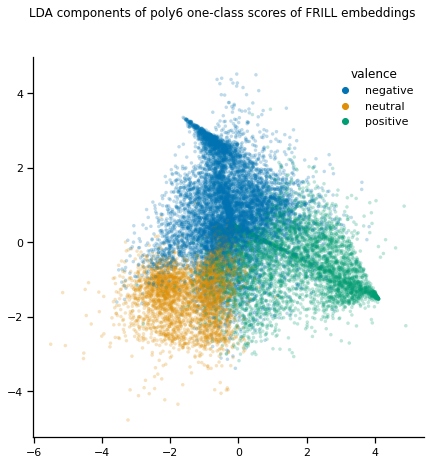

Text(0.5, 0.98, 'per-class oc-poly6 scores of LDA components')

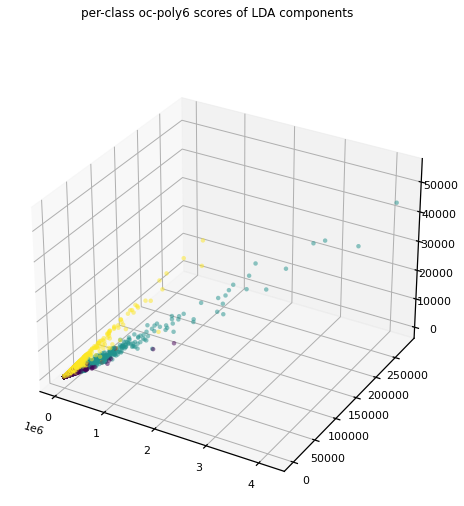

time: 11min 50s


In [10]:
neg_classifier = OneClassSVM(kernel="poly", degree=6).fit(
    neg_data.loc[:, frill_columns]
)
neu_classifier = OneClassSVM(kernel="poly", degree=6).fit(
    neu_data.loc[:, frill_columns]
)
pos_classifier = OneClassSVM(kernel="poly", degree=6).fit(
    pos_data.loc[:, frill_columns]
)
data["ocsvm_poly6_neg"] = neg_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_poly6_neu"] = neu_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_poly6_pos"] = pos_classifier.score_samples(data.loc[:, frill_columns])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.ocsvm_poly6_neg,
    data.ocsvm_poly6_neu,
    data.ocsvm_poly6_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-poly6 scores of FRILL embeddings")
plt.show()

lda = LinearDiscriminantAnalysis().fit_transform(
    data[["ocsvm_poly6_neg", "ocsvm_poly6_neu", "ocsvm_poly6_pos"]], labels.valence,
)
data["oc-poly6_LDA1"] = lda[:, 0]
data["oc-poly6_LDA2"] = lda[:, 1]
sns.scatterplot(
    x=data["oc-poly6_LDA1"],
    y=data["oc-poly6_LDA2"],
    hue=hue_labels,
    data=data,
    palette="colorblind",
    hue_order=["negative", "neutral", "positive"],
    alpha=0.25,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)
fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)
sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("LDA components of poly6 one-class scores of FRILL embeddings")
plt.show()

neg_classifier = OneClassSVM(kernel="poly", degree=6).fit(
    neg_data.loc[:, ["LDA1", "LDA2"]]
)
neu_classifier = OneClassSVM(kernel="poly", degree=6).fit(
    neu_data.loc[:, ["LDA1", "LDA2"]]
)
pos_classifier = OneClassSVM(kernel="poly", degree=6).fit(
    pos_data.loc[:, ["LDA1", "LDA2"]]
)
data["LDA_poly6_neg"] = neg_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_poly6_neu"] = neu_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_poly6_pos"] = pos_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.LDA_poly6_neg,
    data.LDA_poly6_neu,
    data.LDA_poly6_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-poly6 scores of LDA components")
plt.show()

_ = gc_collect()

Text(0.5, 0.98, 'per-class oc-poly7 scores of FRILL embeddings')

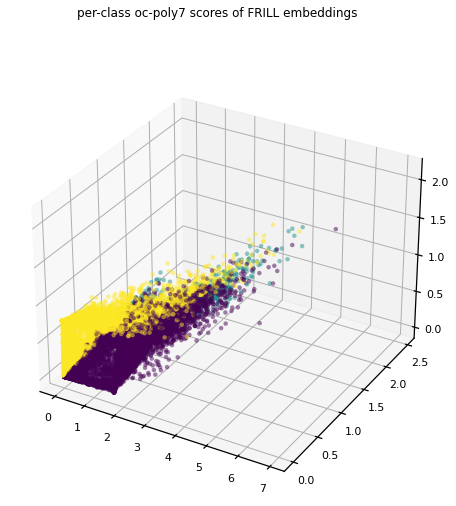

<AxesSubplot:xlabel='oc-poly7_LDA1', ylabel='oc-poly7_LDA2'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'LDA components of poly7 one-class scores of FRILL embeddings')

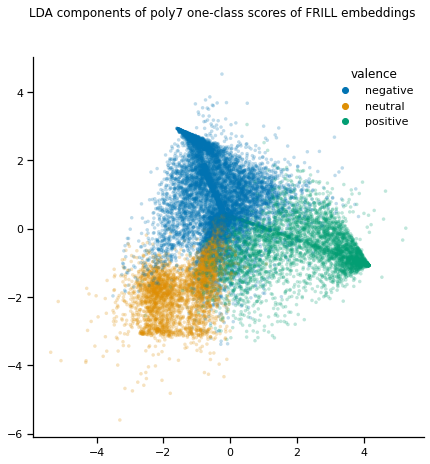

In [ ]:
neg_classifier = OneClassSVM(kernel="poly", degree=7).fit(
    neg_data.loc[:, frill_columns]
)
neu_classifier = OneClassSVM(kernel="poly", degree=7).fit(
    neu_data.loc[:, frill_columns]
)
pos_classifier = OneClassSVM(kernel="poly", degree=7).fit(
    pos_data.loc[:, frill_columns]
)
data["ocsvm_poly7_neg"] = neg_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_poly7_neu"] = neu_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_poly7_pos"] = pos_classifier.score_samples(data.loc[:, frill_columns])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.ocsvm_poly7_neg,
    data.ocsvm_poly7_neu,
    data.ocsvm_poly7_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-poly7 scores of FRILL embeddings")
plt.show()

lda = LinearDiscriminantAnalysis().fit_transform(
    data[["ocsvm_poly7_neg", "ocsvm_poly7_neu", "ocsvm_poly7_pos"]], labels.valence,
)
data["oc-poly7_LDA1"] = lda[:, 0]
data["oc-poly7_LDA2"] = lda[:, 1]
sns.scatterplot(
    x=data["oc-poly7_LDA1"],
    y=data["oc-poly7_LDA2"],
    hue=hue_labels,
    data=data,
    palette="colorblind",
    hue_order=["negative", "neutral", "positive"],
    alpha=0.25,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)
fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)
sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("LDA components of poly7 one-class scores of FRILL embeddings")
plt.show()

Text(0.5, 0.98, 'per-class oc-poly7 scores of LDA components')

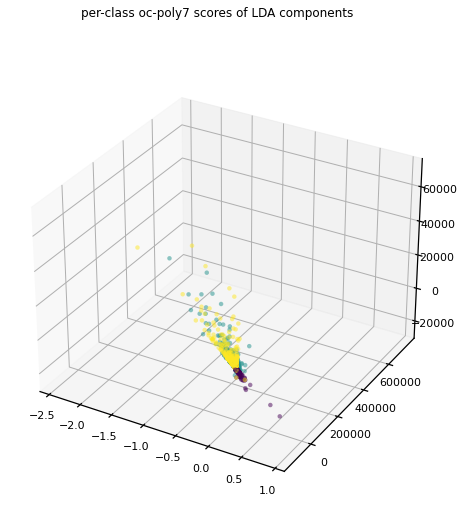

time: 1h 59min 53s


In [13]:
neg_classifier = OneClassSVM(kernel="poly", degree=7).fit(
    neg_data.loc[:, ["LDA1", "LDA2"]]
)
neu_classifier = OneClassSVM(kernel="poly", degree=7).fit(
    neu_data.loc[:, ["LDA1", "LDA2"]]
)
pos_classifier = OneClassSVM(kernel="poly", degree=7).fit(
    pos_data.loc[:, ["LDA1", "LDA2"]]
)
data["LDA_poly7_neg"] = neg_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_poly7_neu"] = neu_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_poly7_pos"] = pos_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.LDA_poly7_neg,
    data.LDA_poly7_neu,
    data.LDA_poly7_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-poly7 scores of LDA components")
plt.show()

_ = gc_collect()

Text(0.5, 0.98, 'per-class oc-poly8 scores of FRILL embeddings')

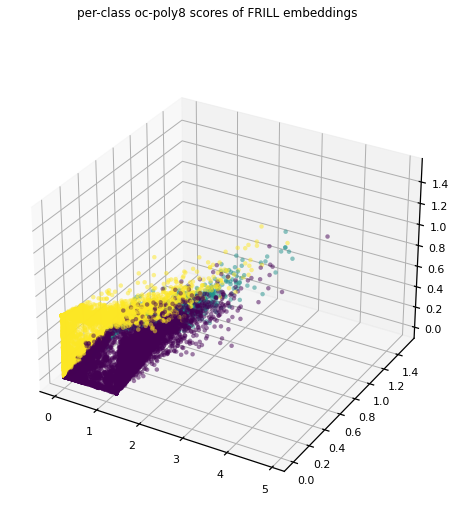

<AxesSubplot:xlabel='oc-poly8_LDA1', ylabel='oc-poly8_LDA2'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'LDA components of poly8 one-class scores of FRILL embeddings')

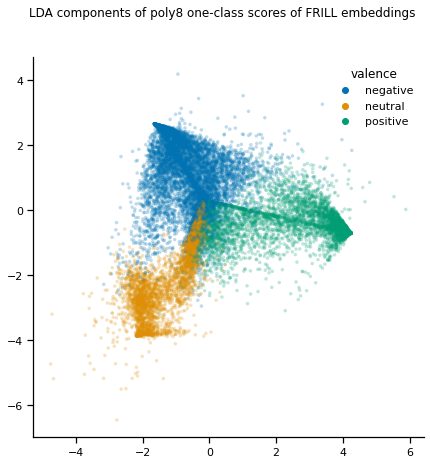

Text(0.5, 0.98, 'per-class oc-poly8 scores of LDA components')

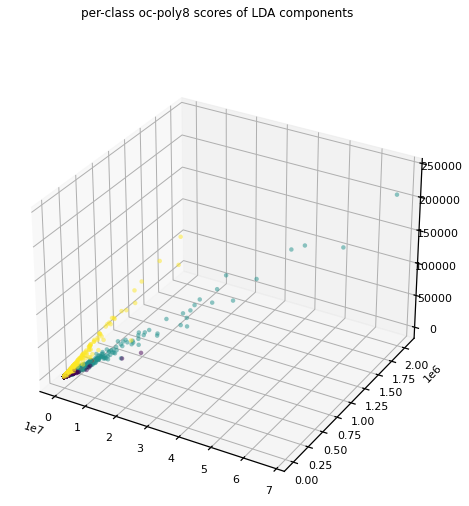

time: 13min 25s


In [8]:
neg_classifier = OneClassSVM(kernel="poly", degree=8).fit(
    neg_data.loc[:, frill_columns]
)
neu_classifier = OneClassSVM(kernel="poly", degree=8).fit(
    neu_data.loc[:, frill_columns]
)
pos_classifier = OneClassSVM(kernel="poly", degree=8).fit(
    pos_data.loc[:, frill_columns]
)
data["ocsvm_poly8_neg"] = neg_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_poly8_neu"] = neu_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_poly8_pos"] = pos_classifier.score_samples(data.loc[:, frill_columns])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.ocsvm_poly8_neg,
    data.ocsvm_poly8_neu,
    data.ocsvm_poly8_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-poly8 scores of FRILL embeddings")
plt.show()

lda = LinearDiscriminantAnalysis().fit_transform(
    data[["ocsvm_poly8_neg", "ocsvm_poly8_neu", "ocsvm_poly8_pos"]], labels.valence,
)
data["oc-poly8_LDA1"] = lda[:, 0]
data["oc-poly8_LDA2"] = lda[:, 1]
sns.scatterplot(
    x=data["oc-poly8_LDA1"],
    y=data["oc-poly8_LDA2"],
    hue=hue_labels,
    data=data,
    palette="colorblind",
    hue_order=["negative", "neutral", "positive"],
    alpha=0.25,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)
fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)
sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("LDA components of poly8 one-class scores of FRILL embeddings")
plt.show()

neg_classifier = OneClassSVM(kernel="poly", degree=8).fit(
    neg_data.loc[:, ["LDA1", "LDA2"]]
)
neu_classifier = OneClassSVM(kernel="poly", degree=8).fit(
    neu_data.loc[:, ["LDA1", "LDA2"]]
)
pos_classifier = OneClassSVM(kernel="poly", degree=8).fit(
    pos_data.loc[:, ["LDA1", "LDA2"]]
)
data["LDA_poly8_neg"] = neg_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_poly8_neu"] = neu_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_poly8_pos"] = pos_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.LDA_poly8_neg,
    data.LDA_poly8_neu,
    data.LDA_poly8_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-poly8 scores of LDA components")
plt.show()

_ = gc_collect()

Text(0.5, 0.98, 'per-class oc-poly10 scores of FRILL embeddings')

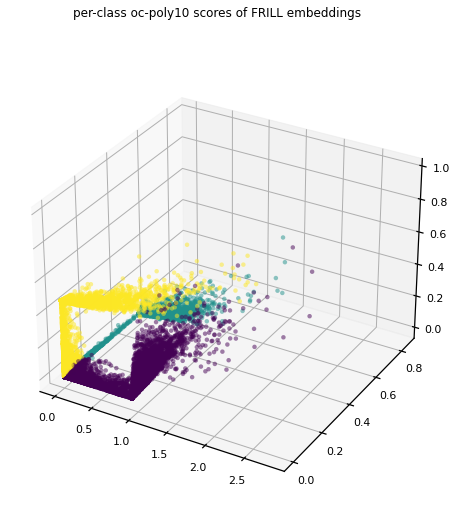

<AxesSubplot:xlabel='oc-poly10_LDA1', ylabel='oc-poly10_LDA2'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'LDA components of poly10 one-class scores of FRILL embeddings')

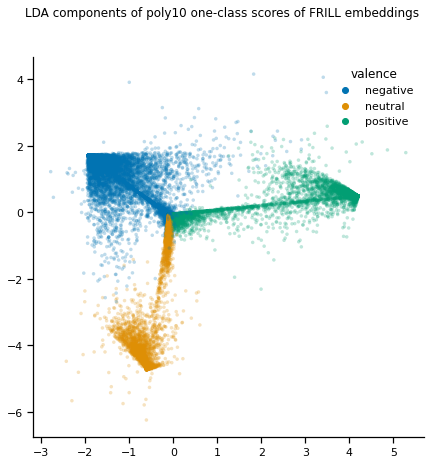

Text(0.5, 0.98, 'per-class oc-poly10 scores of LDA components')

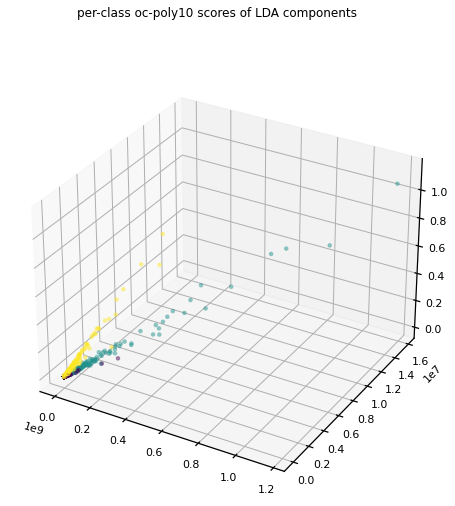

time: 14min 51s


In [9]:
neg_classifier = OneClassSVM(kernel="poly", degree=10).fit(
    neg_data.loc[:, frill_columns]
)
neu_classifier = OneClassSVM(kernel="poly", degree=10).fit(
    neu_data.loc[:, frill_columns]
)
pos_classifier = OneClassSVM(kernel="poly", degree=10).fit(
    pos_data.loc[:, frill_columns]
)
data["ocsvm_poly10_neg"] = neg_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_poly10_neu"] = neu_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_poly10_pos"] = pos_classifier.score_samples(data.loc[:, frill_columns])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.ocsvm_poly10_neg,
    data.ocsvm_poly10_neu,
    data.ocsvm_poly10_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-poly10 scores of FRILL embeddings")
plt.show()

lda = LinearDiscriminantAnalysis().fit_transform(
    data[["ocsvm_poly10_neg", "ocsvm_poly10_neu", "ocsvm_poly10_pos"]], labels.valence,
)
data["oc-poly10_LDA1"] = lda[:, 0]
data["oc-poly10_LDA2"] = lda[:, 1]
sns.scatterplot(
    x=data["oc-poly10_LDA1"],
    y=data["oc-poly10_LDA2"],
    hue=hue_labels,
    data=data,
    palette="colorblind",
    hue_order=["negative", "neutral", "positive"],
    alpha=0.25,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)
fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)
sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("LDA components of poly10 one-class scores of FRILL embeddings")
plt.show()

neg_classifier = OneClassSVM(kernel="poly", degree=10).fit(
    neg_data.loc[:, ["LDA1", "LDA2"]]
)
neu_classifier = OneClassSVM(kernel="poly", degree=10).fit(
    neu_data.loc[:, ["LDA1", "LDA2"]]
)
pos_classifier = OneClassSVM(kernel="poly", degree=10).fit(
    pos_data.loc[:, ["LDA1", "LDA2"]]
)
data["LDA_poly10_neg"] = neg_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_poly10_neu"] = neu_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_poly10_pos"] = pos_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.LDA_poly10_neg,
    data.LDA_poly10_neu,
    data.LDA_poly10_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-poly10 scores of LDA components")
plt.show()

_ = gc_collect()

Text(0.5, 0.98, 'per-class oc-poly12 scores of FRILL embeddings')

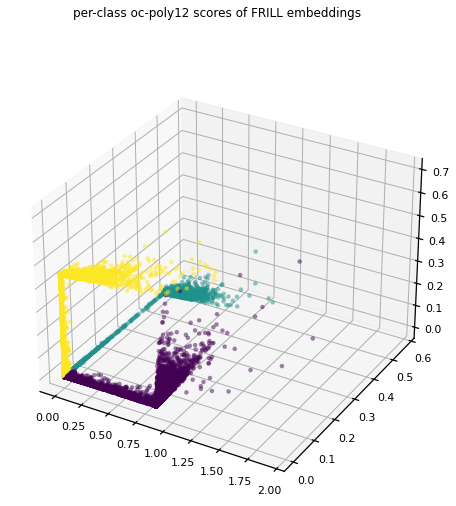

<AxesSubplot:xlabel='oc-poly12_LDA1', ylabel='oc-poly12_LDA2'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'LDA components of poly12 one-class scores of FRILL embeddings')

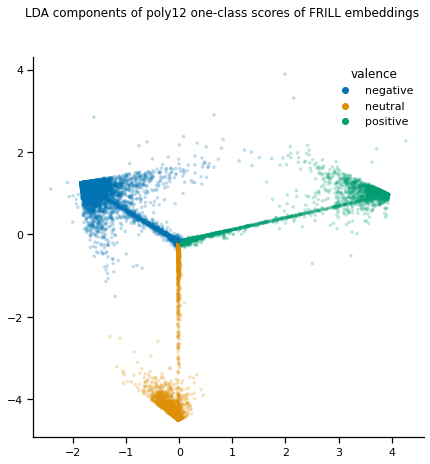

Text(0.5, 0.98, 'per-class oc-poly12 scores of LDA components')

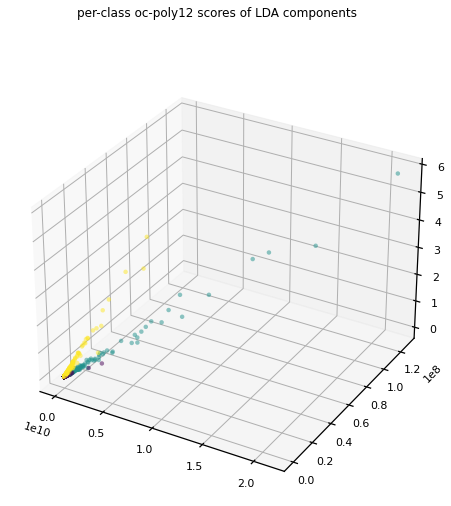

time: 13min 29s


In [10]:
neg_classifier = OneClassSVM(kernel="poly", degree=12).fit(
    neg_data.loc[:, frill_columns]
)
neu_classifier = OneClassSVM(kernel="poly", degree=12).fit(
    neu_data.loc[:, frill_columns]
)
pos_classifier = OneClassSVM(kernel="poly", degree=12).fit(
    pos_data.loc[:, frill_columns]
)
data["ocsvm_poly12_neg"] = neg_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_poly12_neu"] = neu_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_poly12_pos"] = pos_classifier.score_samples(data.loc[:, frill_columns])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.ocsvm_poly12_neg,
    data.ocsvm_poly12_neu,
    data.ocsvm_poly12_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-poly12 scores of FRILL embeddings")
plt.show()

lda = LinearDiscriminantAnalysis().fit_transform(
    data[["ocsvm_poly12_neg", "ocsvm_poly12_neu", "ocsvm_poly12_pos"]], labels.valence,
)
data["oc-poly12_LDA1"] = lda[:, 0]
data["oc-poly12_LDA2"] = lda[:, 1]
sns.scatterplot(
    x=data["oc-poly12_LDA1"],
    y=data["oc-poly12_LDA2"],
    hue=hue_labels,
    data=data,
    palette="colorblind",
    hue_order=["negative", "neutral", "positive"],
    alpha=0.25,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)
fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)
sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("LDA components of poly12 one-class scores of FRILL embeddings")
plt.show()

neg_classifier = OneClassSVM(kernel="poly", degree=12).fit(
    neg_data.loc[:, ["LDA1", "LDA2"]]
)
neu_classifier = OneClassSVM(kernel="poly", degree=12).fit(
    neu_data.loc[:, ["LDA1", "LDA2"]]
)
pos_classifier = OneClassSVM(kernel="poly", degree=12).fit(
    pos_data.loc[:, ["LDA1", "LDA2"]]
)
data["LDA_poly12_neg"] = neg_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_poly12_neu"] = neu_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_poly12_pos"] = pos_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.LDA_poly12_neg,
    data.LDA_poly12_neu,
    data.LDA_poly12_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-poly12 scores of LDA components")
plt.show()

_ = gc_collect()

Text(0.5, 0.98, 'per-class oc-poly14 scores of FRILL embeddings')

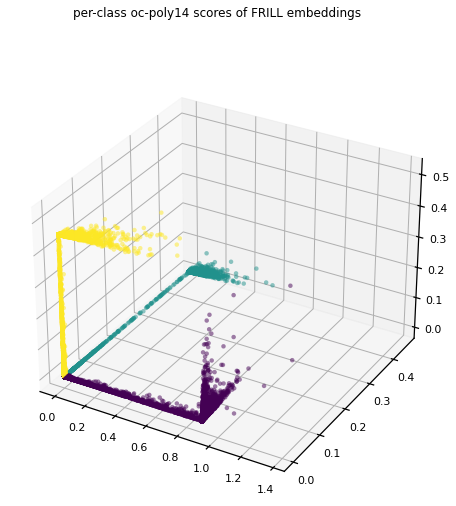

<AxesSubplot:xlabel='oc-poly14_LDA1', ylabel='oc-poly14_LDA2'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'LDA components of poly14 one-class scores of FRILL embeddings')

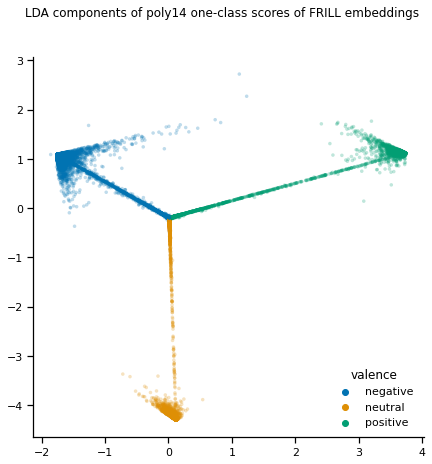

Text(0.5, 0.98, 'per-class oc-poly14 scores of LDA components')

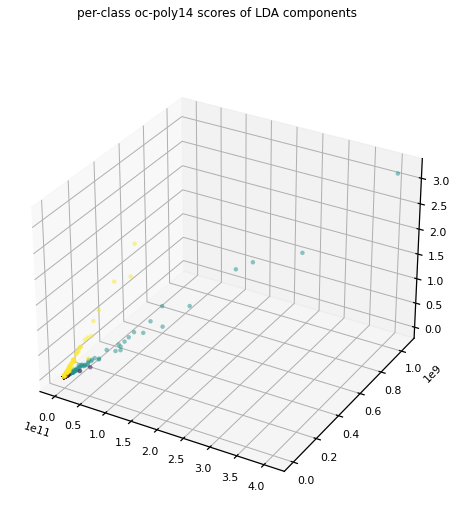

time: 13min 40s


In [11]:
neg_classifier = OneClassSVM(kernel="poly", degree=14).fit(
    neg_data.loc[:, frill_columns]
)
neu_classifier = OneClassSVM(kernel="poly", degree=14).fit(
    neu_data.loc[:, frill_columns]
)
pos_classifier = OneClassSVM(kernel="poly", degree=14).fit(
    pos_data.loc[:, frill_columns]
)
data["ocsvm_poly14_neg"] = neg_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_poly14_neu"] = neu_classifier.score_samples(data.loc[:, frill_columns])
data["ocsvm_poly14_pos"] = pos_classifier.score_samples(data.loc[:, frill_columns])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.ocsvm_poly14_neg,
    data.ocsvm_poly14_neu,
    data.ocsvm_poly14_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-poly14 scores of FRILL embeddings")
plt.show()

lda = LinearDiscriminantAnalysis().fit_transform(
    data[["ocsvm_poly14_neg", "ocsvm_poly14_neu", "ocsvm_poly14_pos"]], labels.valence,
)
data["oc-poly14_LDA1"] = lda[:, 0]
data["oc-poly14_LDA2"] = lda[:, 1]
sns.scatterplot(
    x=data["oc-poly14_LDA1"],
    y=data["oc-poly14_LDA2"],
    hue=hue_labels,
    data=data,
    palette="colorblind",
    hue_order=["negative", "neutral", "positive"],
    alpha=0.25,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)
fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)
sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("LDA components of poly14 one-class scores of FRILL embeddings")
plt.show()

neg_classifier = OneClassSVM(kernel="poly", degree=14).fit(
    neg_data.loc[:, ["LDA1", "LDA2"]]
)
neu_classifier = OneClassSVM(kernel="poly", degree=14).fit(
    neu_data.loc[:, ["LDA1", "LDA2"]]
)
pos_classifier = OneClassSVM(kernel="poly", degree=14).fit(
    pos_data.loc[:, ["LDA1", "LDA2"]]
)
data["LDA_poly14_neg"] = neg_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_poly14_neu"] = neu_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
data["LDA_poly14_pos"] = pos_classifier.score_samples(data.loc[:, ["LDA1", "LDA2"]])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data.LDA_poly14_neg,
    data.LDA_poly14_neu,
    data.LDA_poly14_pos,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=labels.valence,
)
plt.suptitle("per-class oc-poly14 scores of LDA components")
plt.show()

_ = gc_collect()

# Discussion

Potentially useful features. Hopefully, they'll make redundant any benefit the slow-fitting SVCs have over LogReg and Ridge et al.

The odd-degreed polynomial fits are much much slower after degree=3. But the high-order even ones seem okay. They make some pretty well separated plots. I hope this holds in cross validation.

In [ ]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

[^top](#Contents)